# Forecasting Hourly Energy Consumption with XGBoost

Notebook found at: https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost/data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
pjme = pd.read_csv('data/PJME_hourly.csv', index_col=[0], parse_dates=[0])

### Basic EDA

In [3]:
pjme.head(5)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


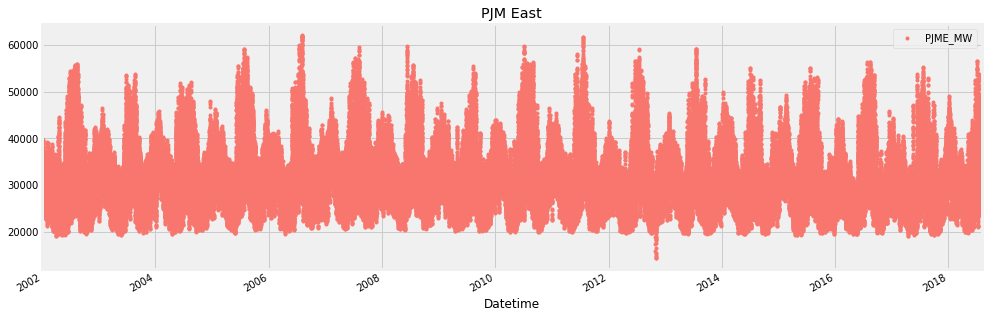

In [4]:
# Plotting timeseries
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
temp_plot = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

### Train/Test Split

In [5]:
split_date = '01-JAN-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

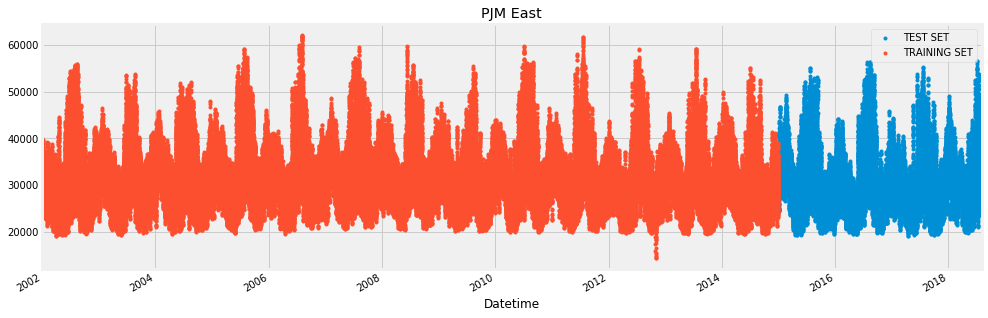

In [6]:
temp_plot = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

### Create Features

In [7]:
def create_features(df, label=None):
    """Creates time series from a datetime index"""
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    
    if label:
        y = df[label]
        return X, y
    
    return X
    

In [8]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

### Create XGBoost Model

In [9]:
start = datetime.datetime.now()
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train
end = datetime.datetime.now()
print("Total runtime for XGBoost: ", end-start)

C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[09:14:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29710.4	validation_1-rmse:28762.5
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:26822.6	validation_1-rmse:25892.2
[2]	validation_0-rmse:24211.2	validation_1-rmse:23286.6
[3]	validation_0-rmse:21885	validation_1-rmse:20967.5
[4]	validation_0-rmse:19780.3	validation_1-rmse:18868.5
[5]	validation_0-rmse:17910	validation_1-rmse:17017.7
[6]	validation_0-rmse:16216.1	validation_1-rmse:15336.4
[7]	validation_0-rmse:14717.8	validation_1-rmse:13861.5
[8]	validation_0-rmse:13377.4	validation_1-rmse:12536.3
[9]	validation_0-rmse:12184.1	validation_1-rmse:11362.1
[10]	validation_0-rmse:11099.4	validation_1-rmse:10298.7
[11]	validation_0-rmse:10135.2	validation_1-rmse:9357.58
[12]	va

[139]	validation_0-rmse:2939.9	validation_1-rmse:3720.9
[140]	validation_0-rmse:2939.16	validation_1-rmse:3719.24
[141]	validation_0-rmse:2935.64	validation_1-rmse:3715.27
[142]	validation_0-rmse:2934.18	validation_1-rmse:3715.1
[143]	validation_0-rmse:2933.73	validation_1-rmse:3715.9
[144]	validation_0-rmse:2933.1	validation_1-rmse:3715.75
[145]	validation_0-rmse:2932.23	validation_1-rmse:3716.29
[146]	validation_0-rmse:2931.2	validation_1-rmse:3717.22
[147]	validation_0-rmse:2930.35	validation_1-rmse:3718.02
[148]	validation_0-rmse:2928.75	validation_1-rmse:3717.76
[149]	validation_0-rmse:2923.14	validation_1-rmse:3712.2
[150]	validation_0-rmse:2920.09	validation_1-rmse:3714.78
[151]	validation_0-rmse:2919.09	validation_1-rmse:3714.25
[152]	validation_0-rmse:2918.28	validation_1-rmse:3713.52
[153]	validation_0-rmse:2917.79	validation_1-rmse:3713.66
[154]	validation_0-rmse:2917.19	validation_1-rmse:3714.73
[155]	validation_0-rmse:2916.37	validation_1-rmse:3714.26
[156]	validation_0-rm

### Feature Importance

Feature importance is a measure of how many times a feature is split up on.

Dayofyear is most commonly used to split trees, hour and year are next most common. Quarter has low importance as it is a function of dayofyear.

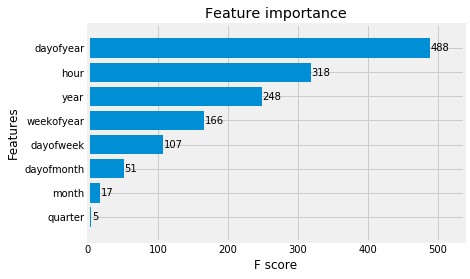

In [10]:
plot_importance(reg, height=.8)

### Forecast on Test Set

In [11]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

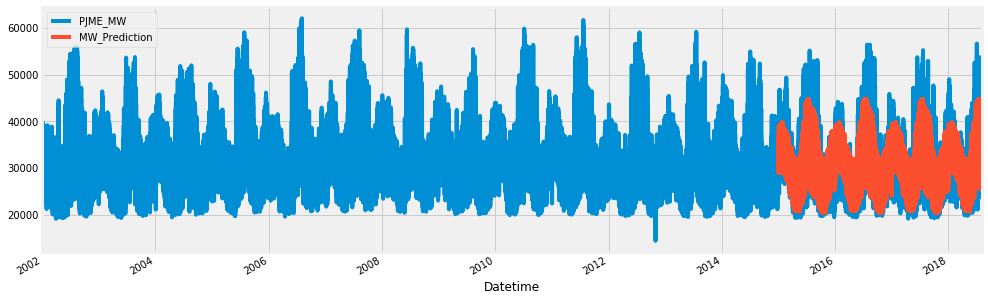

In [12]:
temp_plot = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

### A look at the first month of predictions

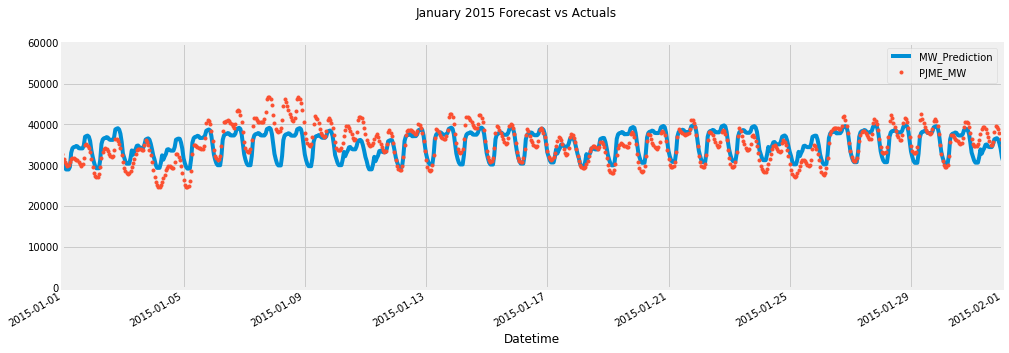

In [13]:
# Plot the forecast against the actual observations
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
temp_chart = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

### A look at the first week of predictions

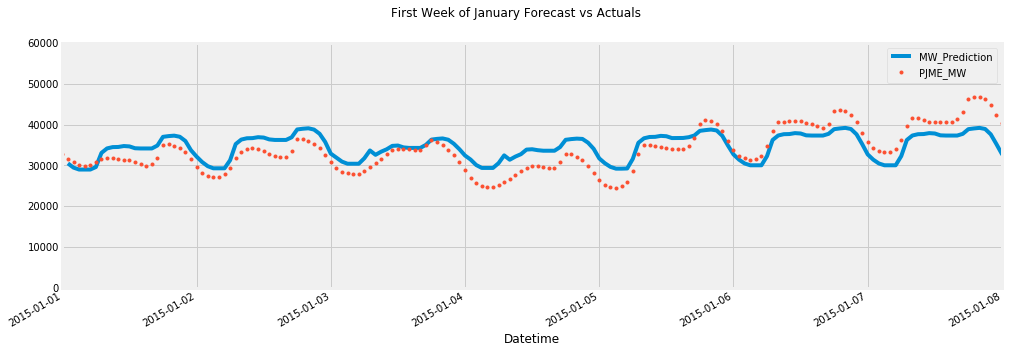

In [14]:
# Plot the forecast against the actual observations
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
temp_plot = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

### A look at the another week of predictions

This time, we take a look at the first week of July

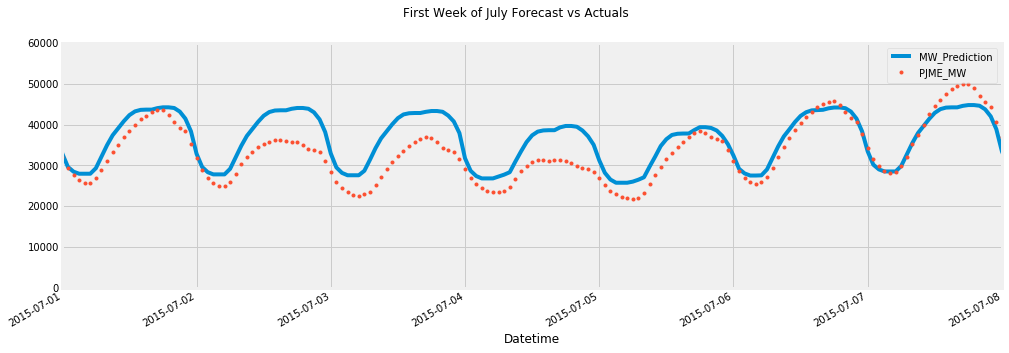

In [15]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

### Error Metrics on Test Set

Error metrics looked at:
* RMSE (Root Mean Squared Error)
* MAE (Mean Absolute Error)
* MAPE (Mean Absolute Percentage Error)

In [39]:
import math

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [41]:
# Evaluate
i = 'MW_Prediction'
print("MSE: ", mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test[i]))
print("RMSE: ", math.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test[i])))
print("MAE: ", mean_absolute_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test[i]))
print("Mean Absolute Percentage Error: {}%".format(round(mean_absolute_percentage_error(pjme_test['PJME_MW'], pjme_test[i]), 4)))
print("\n")

MSE:  13780445.55710396
RMSE:  3712.202251643081
MAE:  2848.891429322955
Mean Absolute Percentage Error: 8.9494%




### Worst vs Best Predicted Days

In [22]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
pjme_test['abs_error_pct'] = pjme_test['abs_error']/pjme_test['PJME_MW']*100
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error', 'abs_error_pct']]

In [23]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error  \
year month dayofmonth                                                          
2016 7     4           28399.958333   36986.964844 -8587.006429  8587.006429   
2017 2     24          26445.083333   33814.503906 -7369.422445  7369.422445   
2015 12    25          24466.083333   31584.923828 -7118.841390  7118.841390   
2017 2     20          27070.583333   34100.781250 -7030.197754  7030.197754   
2015 7     3           30024.875000   37021.031250 -6996.156169  6996.156169   
2017 6     28          30531.208333   37526.589844 -6995.380371  6995.380371   
     2     8           28523.833333   35511.699219 -6987.864258  6987.864258   
     9     2           24201.458333   31180.390625 -6978.933105  6978.933105   
     2     25          24344.458333   31284.279297 -6939.820150  6939.820150   
2018 2     21          27572.500000   34477.417969 -6904.919352  6904.919352   

                       abs_error_pct  
year month dayofmonth                 
2016 7     4               30.030298  
2017 2     24              28.212128  
2015 12    25              29.169730  
2017 2     20              26.257544  
2015 7     3               23.486187  
2017 6     28              22.908198  
     2     8               24.591354  
     9     2               28.439499  
     2     25              29.107123  
2018 2     21              25.478709

As noted in the notebook: 
* Some of the worst misses were holidays, so a holiday indicator could be beneficial

In [24]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error  \
year month dayofmonth                                              
2016 8     13          45185.833333   31753.224609  13432.608887   
           14          44427.333333   31058.818359  13368.514404   
     9     10          40996.166667   29786.179688  11209.987793   
           9           43836.958333   32831.035156  11005.923828   
2015 2     20          44694.041667   33814.503906  10879.535889   
2018 1     6           43565.750000   33435.265625  10130.485921   
2016 8     12          45724.708333   35609.312500  10115.394287   
2017 5     19          38032.583333   28108.976562   9923.606689   
     12    31          39016.000000   29314.683594   9701.315430   
2015 2     21          40918.666667   31284.279297   9634.388184   

                          abs_error  abs_error_pct  
year month dayofmonth                               
2016 8     13          13432.608887      29.369568  
           14          13368.514404      30.137939  
     9     10          11209.987793      26.517790  
           9           11005.923828      24.927798  
2015 2     20          10879.535889      24.332939  
2018 1     6           10130.485921      23.253607  
2016 8     12          10115.394287      21.999036  
2017 5     19           9923.606689      25.277867  
     12    31           9701.315430      24.902547  
2015 2     21           9634.388184      23.513995

In [25]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error  \
year month dayofmonth                                                        
2016 10    3           27705.583333   27775.351562  -69.768148  229.585205   
2015 10    28          28500.958333   28160.875000  340.083740  388.023356   
2016 10    8           25183.333333   25535.669922 -352.337402  401.017090   
     5     1           24503.625000   24795.419922 -291.794515  428.289307   
2017 10    29          24605.666667   24776.271484 -170.605225  474.628988   
2016 9     16          29258.500000   29397.271484 -138.770833  491.070312   
     3     20          27989.416667   27620.132812  369.284831  499.750488   
     10    2           24659.083333   25134.919922 -475.836670  516.188232   
2017 10    14          24949.583333   25399.728516 -450.145996  520.855794   
2015 5     6           28948.666667   28710.271484  238.396077  546.640544   

                       abs_error_pct  
year month dayofmonth                 
2016 10    3                0.873074  
2015 10    28               1.339016  
2016 10    8                1.652783  
     5     1                1.850470  
2017 10    29               2.016699  
2016 9     16               1.611114  
     3     20               1.734309  
     10    2                2.117707  
2017 10    14               2.176842  
2015 5     6                1.852066

### Plotting Worst Predicted Days

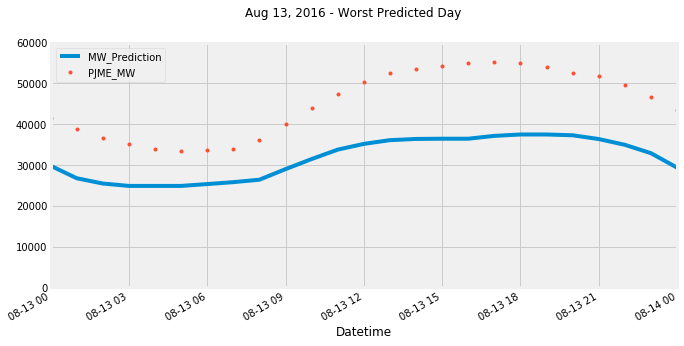

In [26]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

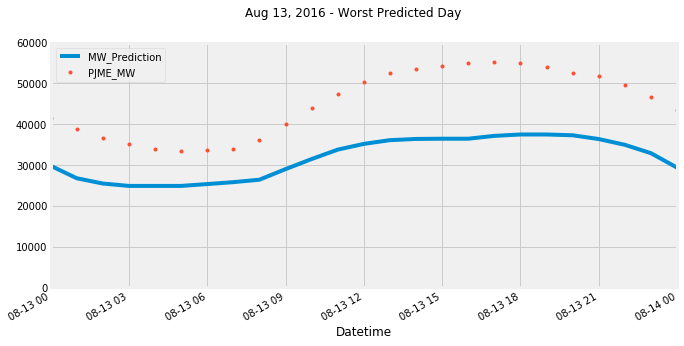

In [27]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

### Plotting Best Predicted Days

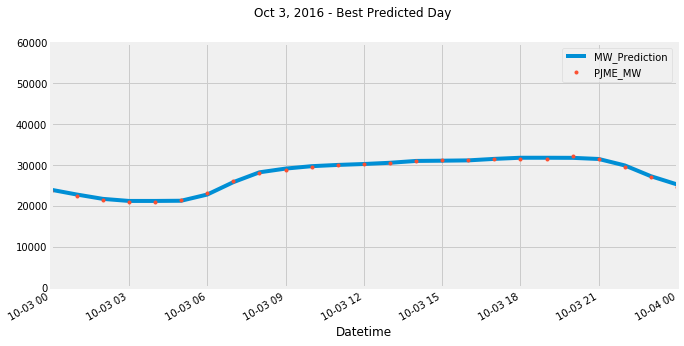

In [28]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')